# **Goal: Recommendation System / Next Best Action**

## **Context**
We have a **random extraction** of a (real world) dataset containing **customers of a large wealth management company**.  

The data is **anonymous, mostly clean, and NOT always normalized/scaled**.  

Our objective is to **estimate investment needs** for these customers using **Data Science techniques**.

### **Why Estimate Investment Needs?**
Identifying customer needs is useful for several reasons, including:

* **Recommender Systems / Next Best Action:**  
  * Needs can serve as **key inputs** for **content-based** or **knowledge-based filtering algorithms**, that allows for personalized services.  
  * This is our **primary focus** in this notebook, i.e., "Know Your Client (KYC)".  

* **Product Targeting & Governance (Regulatory Compliance - MIFID/IDD in EU):**  
  * Regulatory standards require that **customer needs match the investment products offered**. So financial institutions must estimate customer needs.
  * This is essentially an **"institutional view"** of a recommendation system...

<br>

---

## **Dataset Overview**
The dataset, named **"Needs"**, is stored in an **Excel file called Dataset2_Needs.xls**.  
It contains several **potentially relevant features** along with two **target variables**, i.e:

* **AccumulationInvestment**  
  * Indicates a customer preference for **accumulation investing**, typically through **dollar-cost averaging** (i.e., investing small amounts at regular intervals over time, say on a monthly basis).  
  * **Binary (Boolean) response:**  
    * `1 = High propensity`.  
    * `0 = Low propensity`.

- **IncomeInvestment**  
  - Indicates a customer preference for **income investing**, typically through **lump-sum investing** (i.e., one-shot investments).  This is because anyone who aspires to obtain income from coupons and dividends must necessarily already have accumulated capital - a typical need of people who are older than their previous need.
  - **Binary (Boolean) response:**  
    - `1 = High propensity`.  
    - `0 = Low propensity`.  

    **Where do these two response variables come from?** From a **revealed preference scheme**: if the client has an advisor who is considered professionally reliable (this eliminates the possibility of conflict of interest) and has purchased a product that satisfies that need, and the client has also purchased it, we can say with good probability that the advisor has identified the need correctly and the client has that need. In other respects, the machine learning model we are building is a clone of the financial advisor.

<br>

Additionally, we have a **second dataset**, **"Products"**, containing investment products (funds, segregated accounts, unit-linked policies), along with:

* **Product Type:**  
  * `1 = Accumulation` (that is, a product that is good for those who have a high need for accumulation investments)
  * `0 = Income`  (that is, a product that is good for those who have a high need for income investments)

* **Risk Level:**  
  * A **normalized risk score** in the range **$[0,1]$**.  
  * This usually represents the normalized value in $[0, 1]$ of the **[Synthetic Risk and Reward Indicator (SRRI)](https://www.esma.europa.eu/sites/default/files/library/2015/11/10_673.pdf)** of the product, an ordinal variable defined in the range ${1, 7}$ starting from continuous data.

<br>

---

## **Recommendation System Approach**
The recommendation system consists of **two key steps**:

1. **Identifying customers with high investment propensity:**  
   - Using **machine learning models**, we aim to classify customers based on **AccumulationInvestment** (`1 = High propensity`) and/or **IncomeInvestment** (`1 = High propensity`).  

2. **Recommending the most suitable product for each customer:**  
   - For each customer, we match the **most appropriate product** based on:  
     - **Investment need** (Accumulation or Income).  
     - **Risk compatibility** (matching product risk level with the customer profile).  
   - This **personalized recommendation** represents the **Next Best Action** for each client.

<br>


<br>

Let's start with data ingestion.

<br>

In [23]:
!pip install mlxtend

In [24]:
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

import xgboost as xgb
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression

RANDOM_STATE = 42

In [25]:
# Load each sheet into separate DataFrames
# Define the file path in Google Drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Fintech/2/Dataset2_Needs.xls'
# Load each sheet into separate DataFrames
needs_df = pd.read_excel(file_path, sheet_name='Needs')
products_df = pd.read_excel(file_path, sheet_name='Products')
metadata_df = pd.read_excel(file_path, sheet_name='Metadata')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Exploration**

As for the last business case: I keep it minimalist, for the benefit of brevity, to be able to get to the heart of the problem. But you could/can spend tons of time here in order to **understand the problem and the dataset**.

Let's display our variables to better understand the data structure and characteristics of the dataset.

<br>

In [26]:
# Let's see the actual variables names in metadata_df
print("Metadata DataFrame columns:")
print(metadata_df.columns.tolist())

# Let's peek at the first few rows
print("\nFirst few rows of metadata:")
print(metadata_df.head())


Metadata DataFrame columns:
['Metadata', 'Unnamed: 1']

First few rows of metadata:
        Metadata                     Unnamed: 1
0        Clients                            NaN
1             ID                   Numerical ID
2            Age                  Age, in years
3         Gender  Gender (Female = 1, Male = 0)
4  FamilyMembers           Number of components


<br>

We drop ID column as it's not needed for analysis.

<br>

In [27]:
# Drop ID column as it's not needed for analysis
needs_df = needs_df.drop('ID', axis=1)

<br>

Create a formatted table to summarize the dataset (you can expand the number of statistics you look at).


<br>

In [28]:
def create_variable_summary(df, metadata_df):
    # Create empty lists to store the chosen statistics
    stats_dict = {
        'Variable': [],
        'Description': [],
        'Mean': [],
        'Std': [],
        'Missing': [],
        'Min': [],
        'Max': []
    }

    # Create a metadata dictionary for easy lookup
    meta_dict = dict(zip(metadata_df['Metadata'], metadata_df['Unnamed: 1']))

    for col in df.columns:
        stats_dict['Variable'].append(col)
        stats_dict['Description'].append(meta_dict.get(col, 'N/A'))

        # Calculate some statistics for each column
        if pd.api.types.is_numeric_dtype(df[col]):
            stats_dict['Mean'].append(f"{df[col].mean():.2f}")
            stats_dict['Std'].append(f"{df[col].std():.2f}")
            stats_dict['Min'].append(f"{df[col].min():.2f}")
            stats_dict['Max'].append(f"{df[col].max():.2f}")
        else:
            stats_dict['Mean'].append('N/A')
            stats_dict['Std'].append('N/A')
            stats_dict['Min'].append('N/A')
            stats_dict['Max'].append('N/A')

        stats_dict['Missing'].append(df[col].isna().sum())

    return pd.DataFrame(stats_dict)


# Create summary tables
print("NEEDS VARIABLES SUMMARY:")
needs_summary = create_variable_summary(needs_df, metadata_df)
display(needs_summary.style
        .set_properties(**{'text-align': 'left'})
        .hide(axis='index'))

print("\nPRODUCTS VARIABLES SUMMARY:")
products_summary = create_variable_summary(products_df, metadata_df)
display(products_summary.style
        .set_properties(**{'text-align': 'left'})
        .hide(axis='index'))


NEEDS VARIABLES SUMMARY:


Variable,Description,Mean,Std,Missing,Min,Max
Age,"Age, in years",55.25,11.97,0,18.00,97.00
Gender,"Gender (Female = 1, Male = 0)",0.49,0.50,0,0.00,1.00
FamilyMembers,Number of components,2.51,0.76,0,1.00,5.00
FinancialEducation,Normalized level of Financial Education (estimate),0.42,0.15,0,0.04,0.90
RiskPropensity,Normalized Risk propensity from MIFID profile,0.36,0.15,0,0.02,0.88
Income,Income (thousands of euros); estimate,62.99,44.36,0,1.54,365.32
Wealth,Wealth (thousands of euros); sum of investments and cash accounts,93.81,105.47,0,1.06,2233.23
IncomeInvestment,Boolean variable for Income investment; 1 = High propensity,0.38,0.49,0,0.00,1.00
AccumulationInvestment,Boolean variable for Accumulation/growth investment; 1 = High propensity,0.51,0.50,0,0.00,1.00



PRODUCTS VARIABLES SUMMARY:


Variable,Description,Mean,Std,Missing,Min,Max
IDProduct,Product description,6.00,3.32,0,1.00,11.00
Type,"1 = Accumulation product, 0 = Income product",0.64,0.50,0,0.00,1.00
Risk,Normalized Synthetic Risk Indicator,0.43,0.24,0,0.12,0.88


<br>

## Data Transformation and Exploratory Analysis

### 1. Initial setup
* Import required libraries (seaborn, matplotlib, etc).
* Create utility function for histogram plotting.

### 2. Target variables analysis: are they imbalanced?
* Visualize distribution of Income Investment needs.
* Visualize distribution of Accumulation Investment needs.
* Assess class balance for both target variables.

### 3. Wealth variable transformation analysis: is it too fat-tailed?
Display the fat-tailed shape of the Wealth variable, and effect of a couple of reasonable transformations on the Wealth variable. We examine three versions of the Wealth variable:
* Original Wealth distribution.
* Log transformation.
* Power transformation (0.1 power).
* Evaluate which transformation better normalizes the distribution, identifying the most appropriate transformation for leptokurtic, skewed wealth data.

### 4. Some feature engineering and scaling
* Apply log transformation to Wealth and Income.
* Normalize selected variables using MinMaxScaler.
* Create a standardized feature set for modeling.

### 5. Multivariate analysis
* Generate a correlation matrix heatmap for all numeric variables.
* Create pairwise relationships visualization.
* Examine relationships between transformed variables and target variables.

<br>


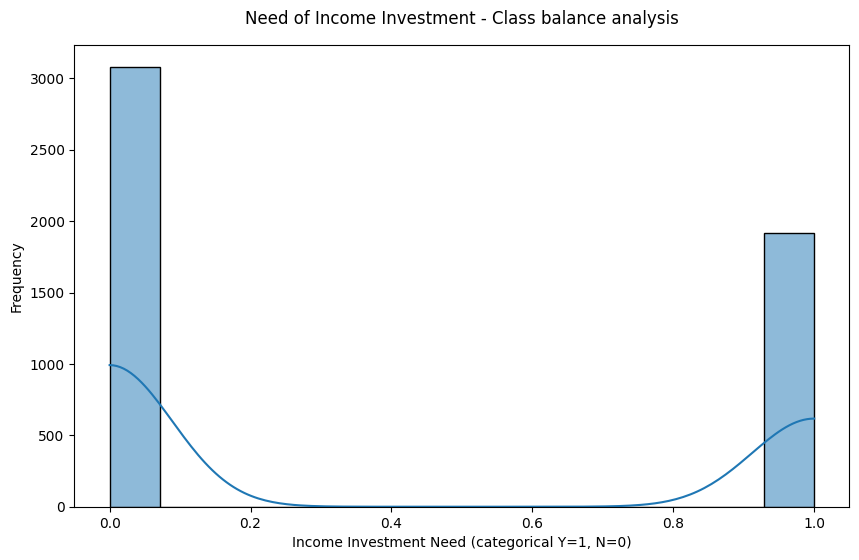

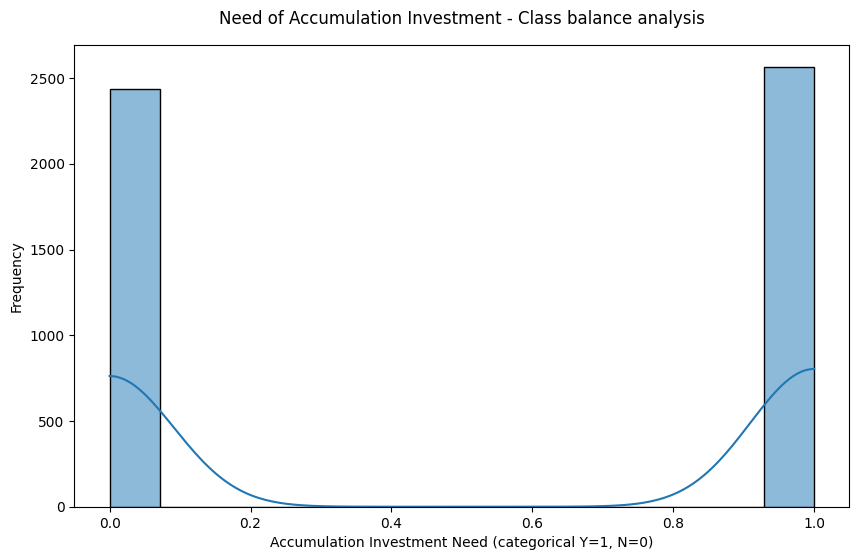

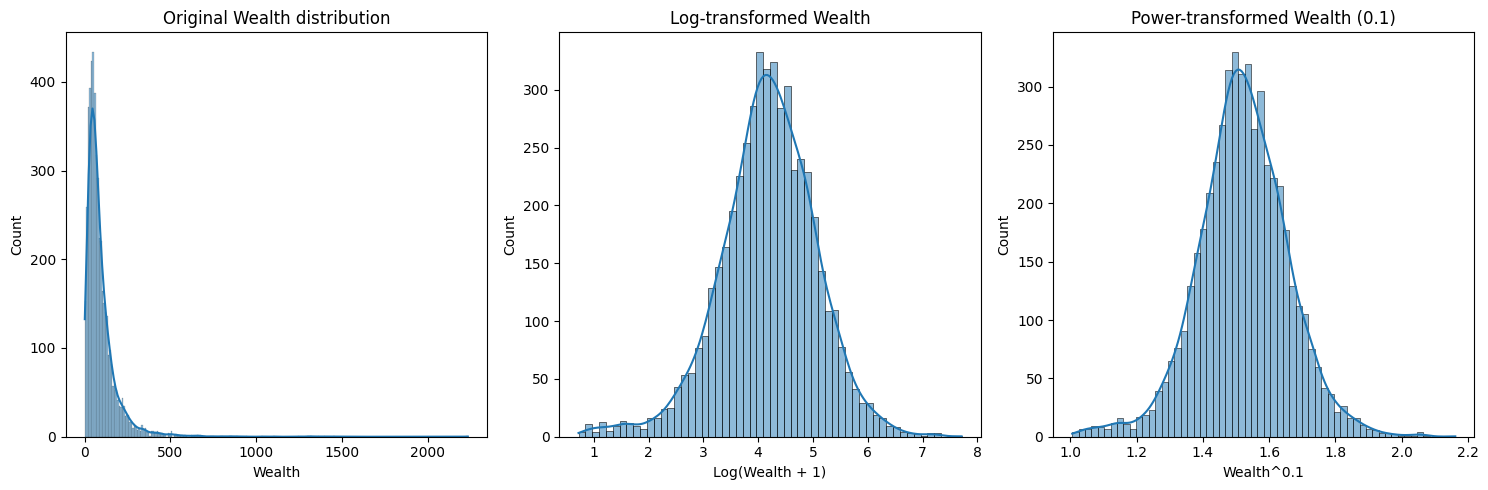

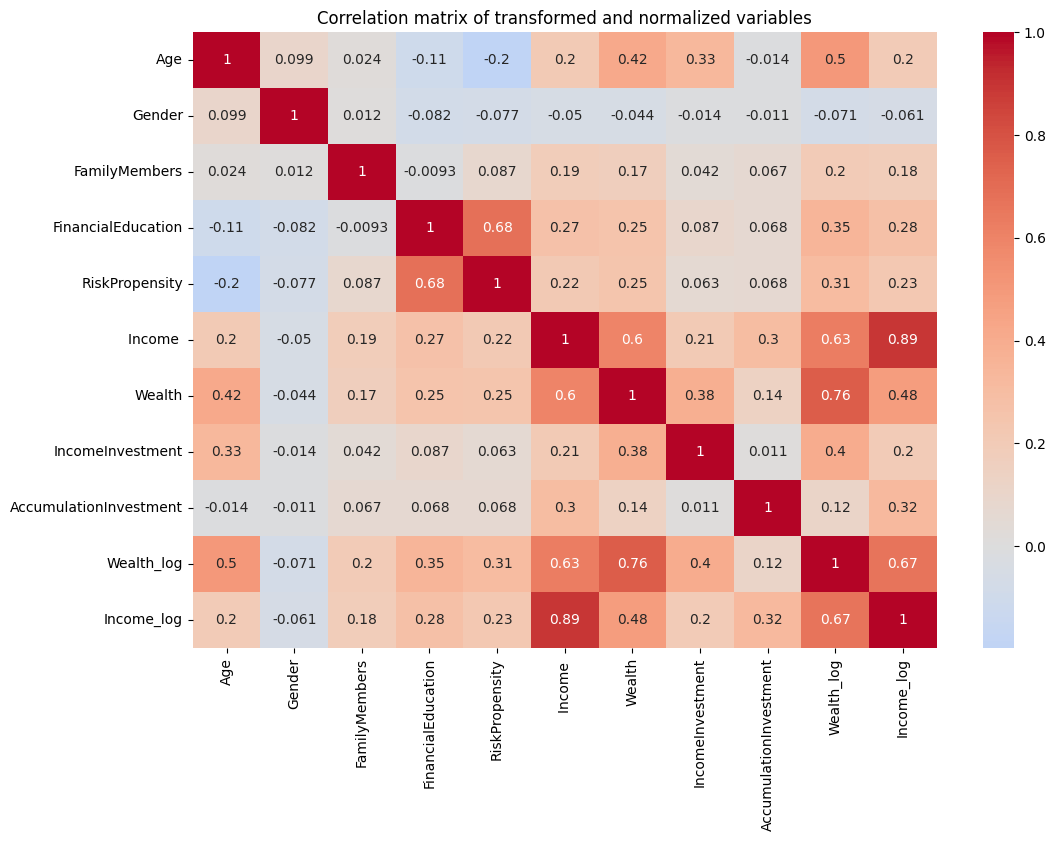

<Figure size 1500x1500 with 0 Axes>

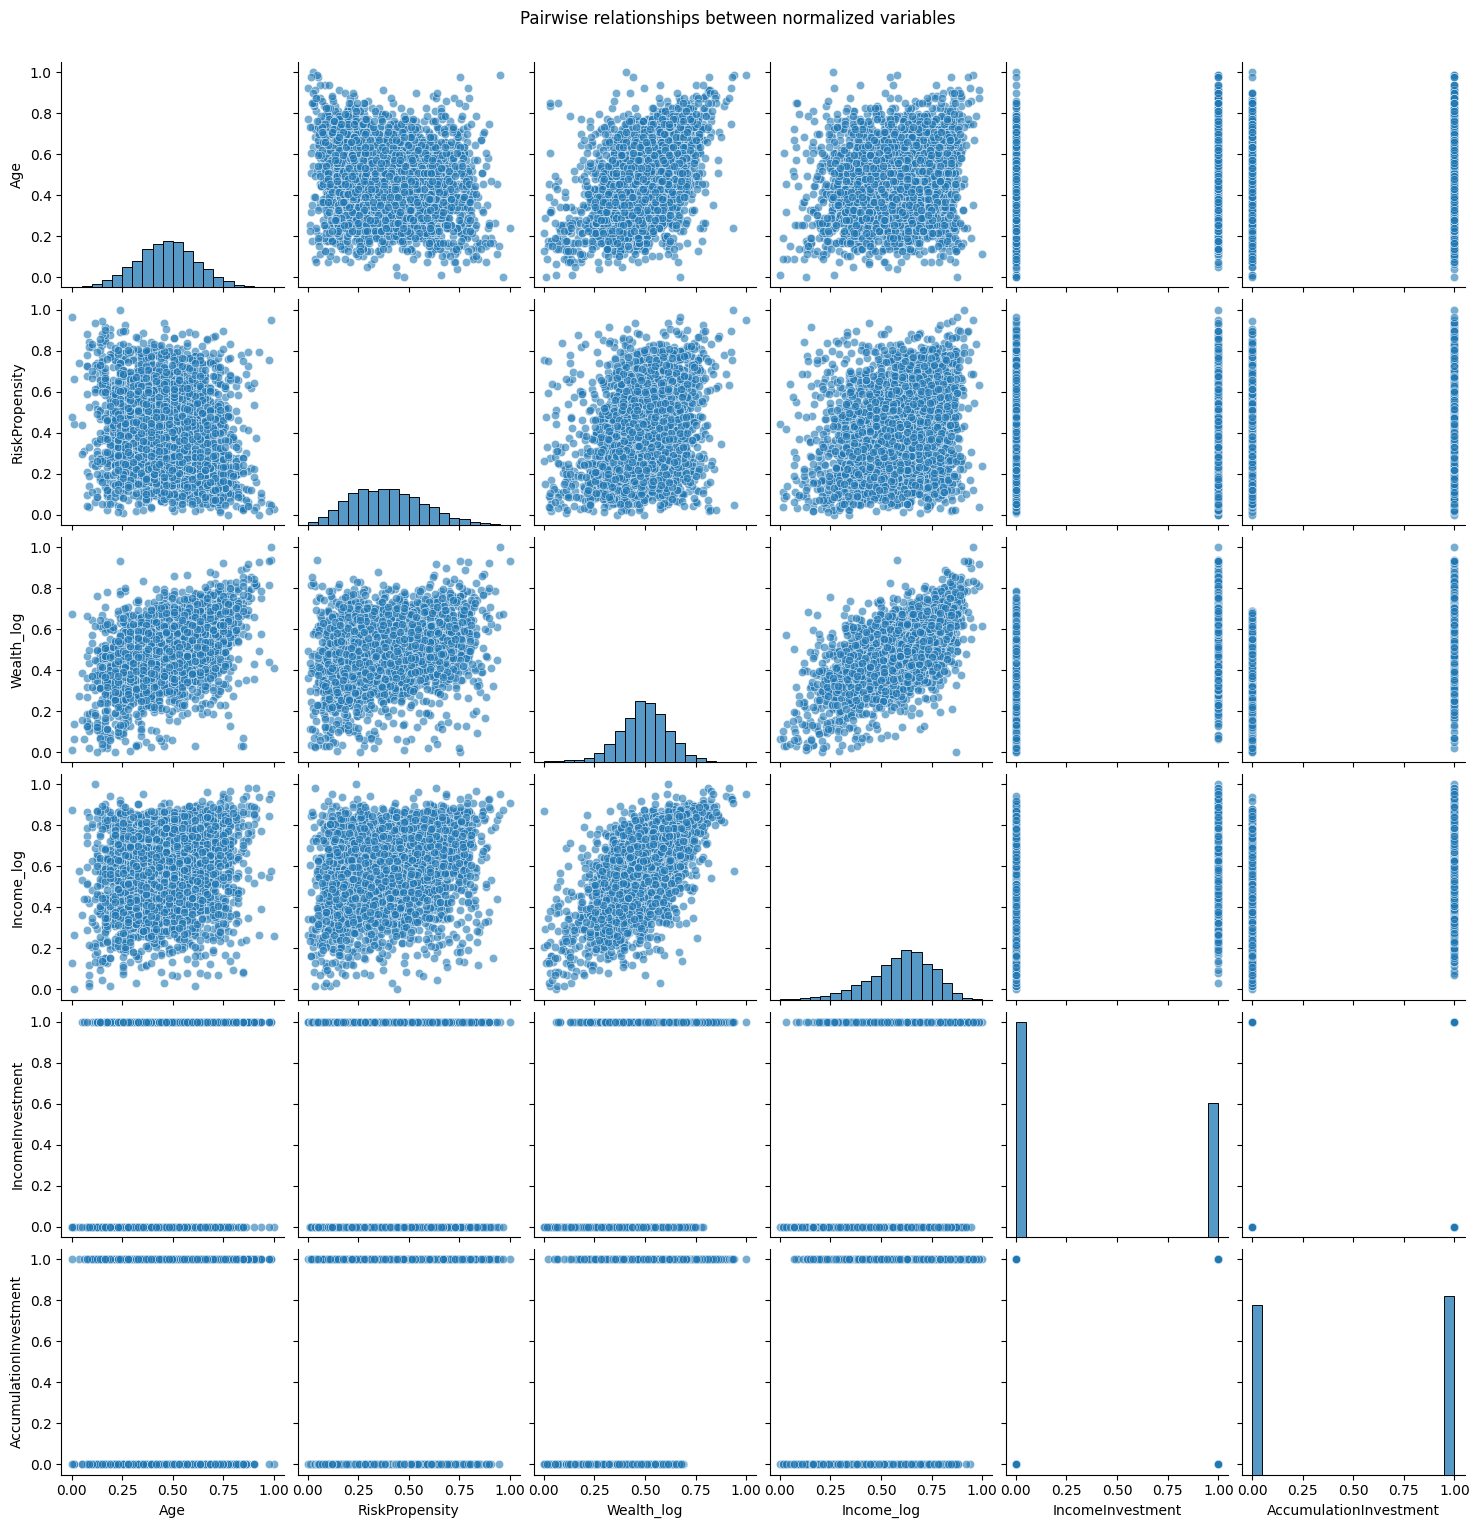

In [29]:


# Create df with all transformations and normalizations
transformed_df = needs_df.copy()

# Create a function for histogram plotting
def plot_histogram(data, title, xlabel, ylabel="Frequency"):
    plt.figure(figsize=(10, 6))
    sns.histplot(data, kde=True)
    plt.title(title, pad=15)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


# Plot class balance histograms
plot_histogram(needs_df.IncomeInvestment,
              'Need of Income Investment - Class balance analysis',
              'Income Investment Need (categorical Y=1, N=0)')

plot_histogram(needs_df.AccumulationInvestment,
              'Need of Accumulation Investment - Class balance analysis',
              'Accumulation Investment Need (categorical Y=1, N=0)')

# Wealth transformation analysis
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Original distribution
sns.histplot(needs_df.Wealth, kde=True, ax=ax1)
ax1.set_title('Original Wealth distribution')
ax1.set_xlabel('Wealth')

# Log transformation
sns.histplot(np.log1p(needs_df.Wealth), kde=True, ax=ax2)
ax2.set_title('Log-transformed Wealth')
ax2.set_xlabel('Log(Wealth + 1)')

# Power transformation
sns.histplot(np.power(needs_df.Wealth, 0.1), kde=True, ax=ax3)
ax3.set_title('Power-transformed Wealth (0.1)')
ax3.set_xlabel('Wealth^0.1')

plt.tight_layout()
plt.show()

# Apply log transformations
transformed_df['Wealth_log'] = np.log1p(transformed_df['Wealth'])
transformed_df['Income_log'] = np.log1p(transformed_df['Income '])

# Apply MinMaxScaler to numerical variables
scaler = MinMaxScaler()
vars_to_normalize = ['Age', 'RiskPropensity', 'Wealth_log', 'Income_log']
transformed_df[vars_to_normalize] = scaler.fit_transform(transformed_df[vars_to_normalize])

# Get all numeric columns including transformed ones (and not transformed, for comparison)
numeric_cols = transformed_df.select_dtypes(include=['float64', 'int64']).columns

# Create correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(transformed_df[numeric_cols].corr(),
            annot=True,
            cmap='coolwarm',
            center=0)
plt.title('Correlation matrix of transformed and normalized variables')
plt.show()

# Create enhanced pairplot
vars_to_plot = vars_to_normalize + ['IncomeInvestment', 'AccumulationInvestment']
plt.figure(figsize=(15, 15))
sns.pairplot(transformed_df[vars_to_plot],
             diag_kind='hist',
             plot_kws={'alpha': 0.6},
             diag_kws={'bins': 20})
plt.suptitle('Pairwise relationships between normalized variables', y=1.02)
plt.show()

/tmp/ipython-input-30-1402514397.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=needs_df['Wealth'],


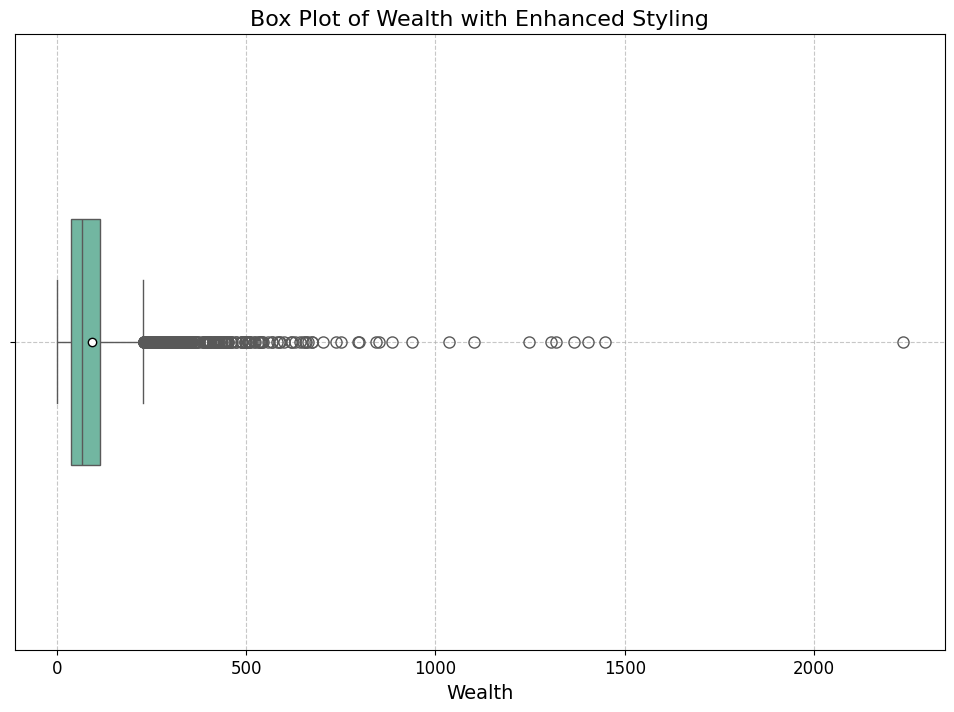

In [30]:
# Assuming 'Wealth' is the column you want to analyze
plt.figure(figsize=(12, 8))
sns.boxplot(x=needs_df['Wealth'],
            width=0.4,  # Adjust box width
            fliersize=8,  # Adjust outlier marker size
            palette="Set2",  # Use a color palette
            showmeans=True,  # Show mean markers
            meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"})  # Customize mean markers
plt.title('Box Plot of Wealth with Enhanced Styling', fontsize=16)  # Increase title font size
plt.xlabel('Wealth', fontsize=14)  # Increase x-axis label font size
plt.xticks(fontsize=12)  # Increase x-axis tick font size
plt.yticks(fontsize=12)  # Increase y-axis tick font size
plt.grid(True, linestyle='--', alpha=0.7)  # Add a grid
plt.show()

In [31]:
# Assuming 'Wealth' is the column you want to analyze
Q1 = needs_df['Wealth'].quantile(0.25)
Q3 = needs_df['Wealth'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = needs_df[(needs_df['Wealth'] < lower_bound) | (needs_df['Wealth'] > upper_bound)]
num_outliers = len(outliers)

in_range_data = needs_df[(needs_df['Wealth'] >= lower_bound) & (needs_df['Wealth'] <= upper_bound)]
num_in_range = len(in_range_data)

print(f"Number of outliers: {num_outliers}")
print(f"Number of data points within range: {num_in_range}")

Number of outliers: 317
Number of data points within range: 4683


/tmp/ipython-input-32-4018872564.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Gender', y='Wealth', data=needs_df,


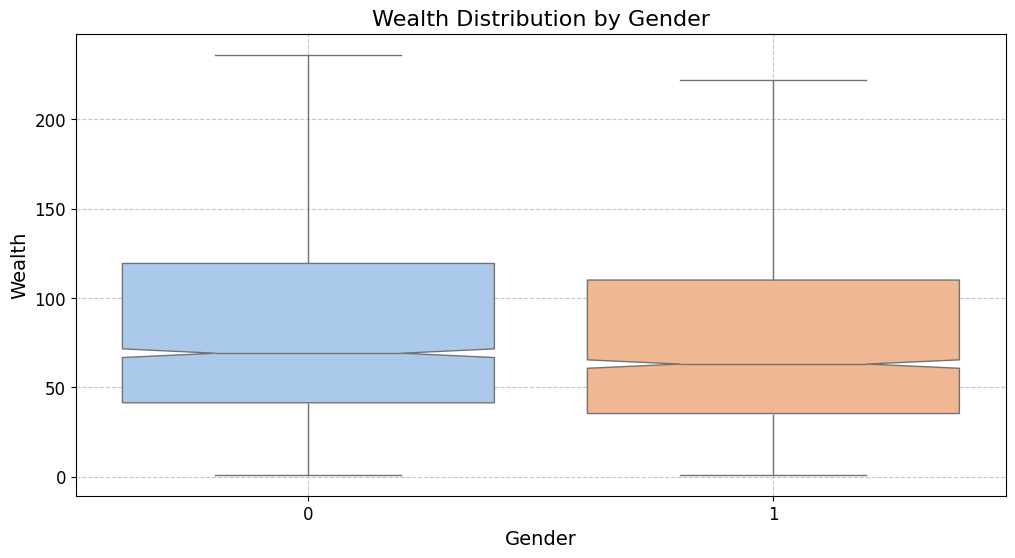

In [32]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Gender', y='Wealth', data=needs_df,
            palette="pastel",  # Use a pastel color palette
            notch=True,  # Add notches for confidence intervals
            showfliers=False)  # Hide outliers for clarity
plt.title('Wealth Distribution by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Wealth', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

<Figure size 800x600 with 0 Axes>

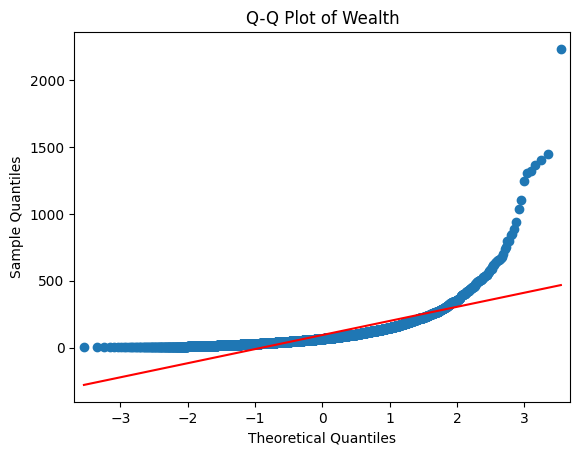

In [33]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
# Assuming 'Wealth' is the column you want to analyze
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
sm.qqplot(needs_df['Wealth'], line='s')  # 's' for standardized line
plt.title('Q-Q Plot of Wealth')
plt.show()

<Figure size 800x600 with 0 Axes>

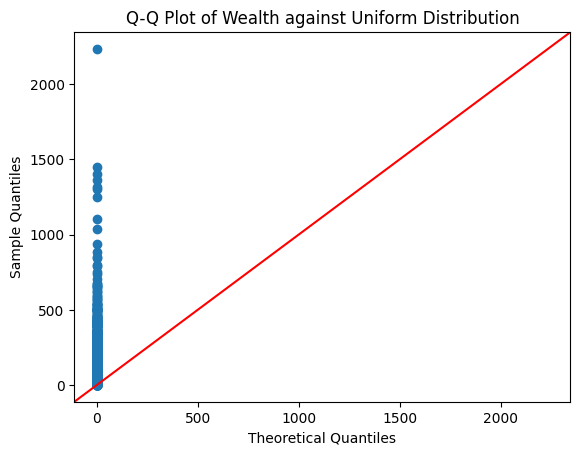

In [34]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats # Import scipy.stats

# Assuming 'Wealth' is the column you want to analyze
plt.figure(figsize=(8, 6))  # Adjust figure size as needed

# Generate data from a uniform distribution
uniform_data = np.random.uniform(low=needs_df['Wealth'].min(),
                                 high=needs_df['Wealth'].max(),
                                 size=len(needs_df['Wealth']))

# Create Q-Q plot with uniform distribution, use stats.uniform
sm.qqplot(needs_df['Wealth'], dist=stats.uniform, line='45') # Changed to stats.uniform
plt.title('Q-Q Plot of Wealth against Uniform Distribution')
plt.show()

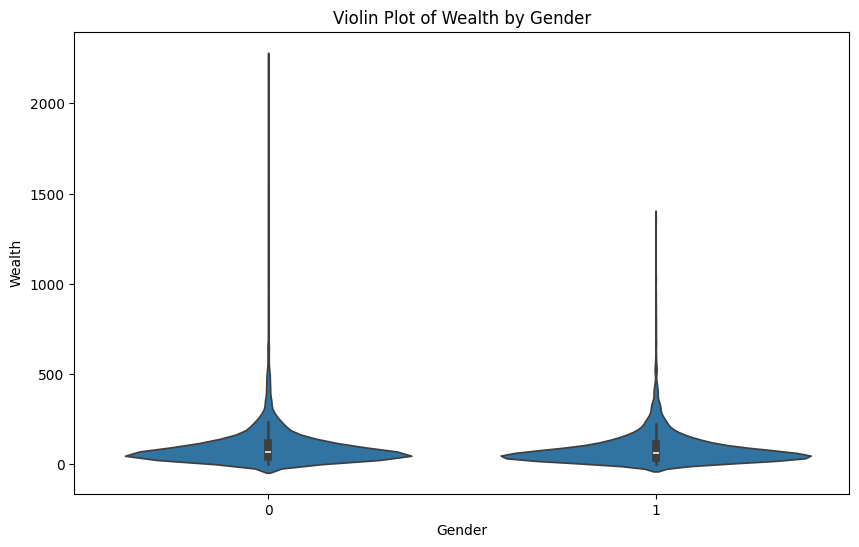

In [35]:
# Assuming 'Wealth' is the numeric variable and 'Gender' is the categorical variable
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.violinplot(x='Gender', y='Wealth', data=needs_df)
plt.title('Violin Plot of Wealth by Gender')
plt.xlabel('Gender')
plt.ylabel('Wealth')
plt.show()

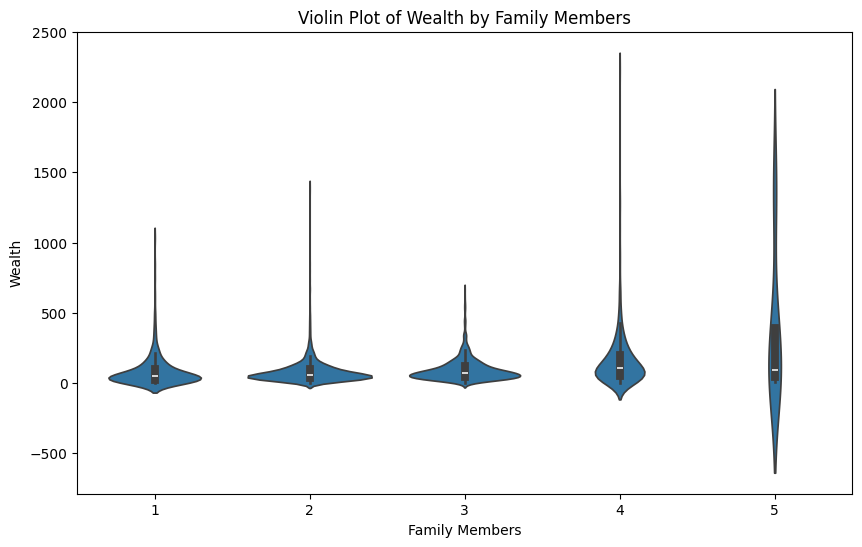

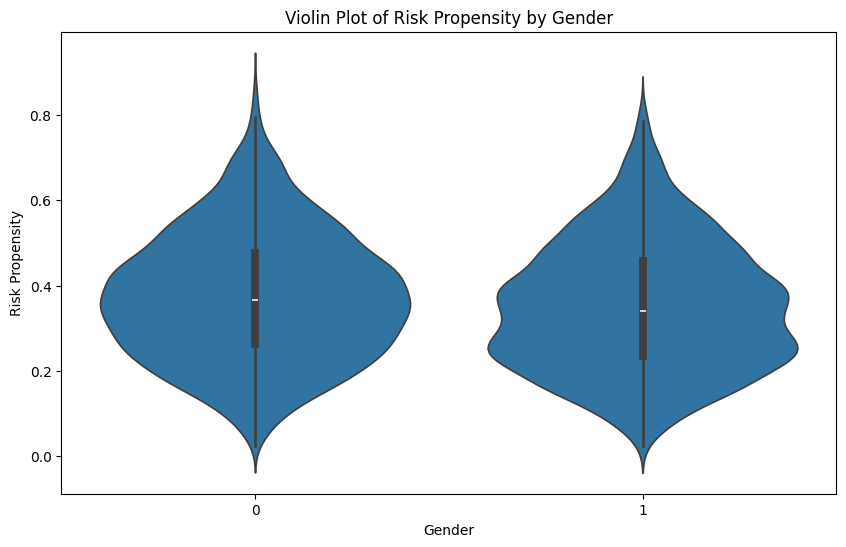

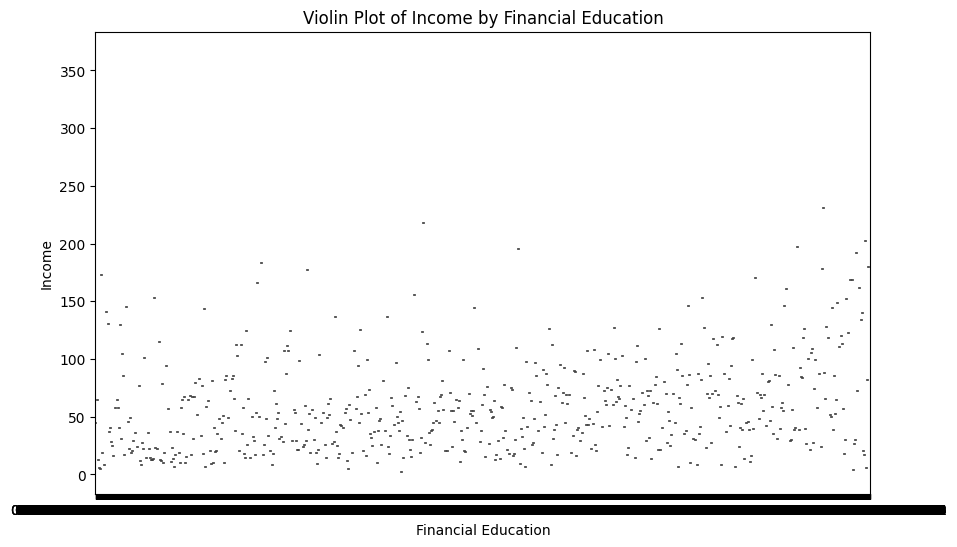

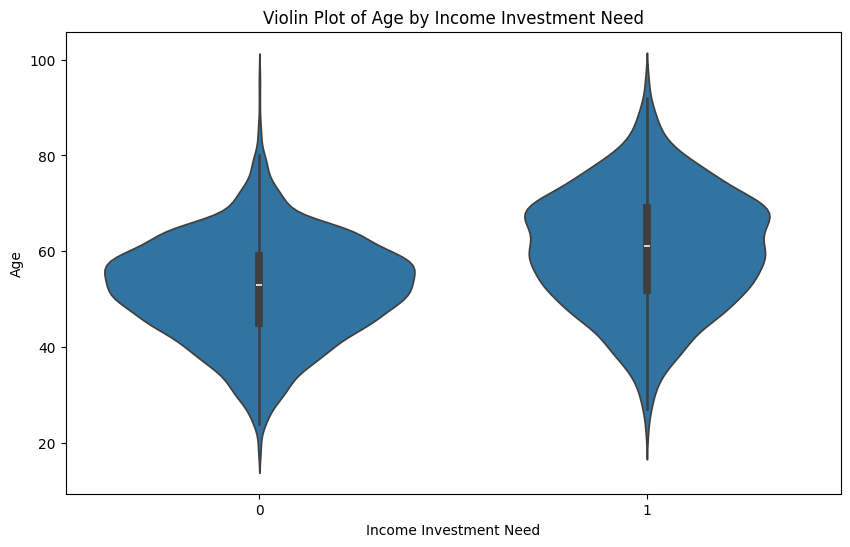

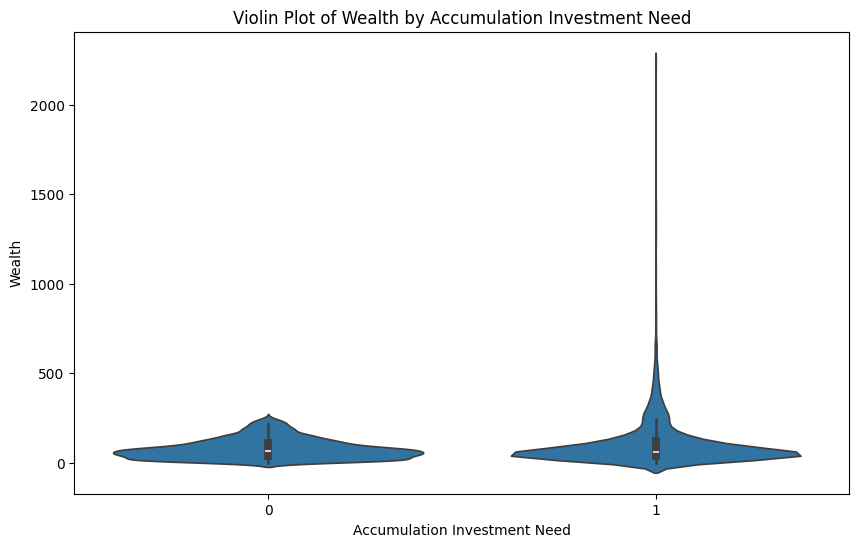

In [36]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='FamilyMembers', y='Wealth', data=needs_df)
plt.title('Violin Plot of Wealth by Family Members')
plt.xlabel('Family Members')
plt.ylabel('Wealth')
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(x='Gender', y='RiskPropensity', data=needs_df)
plt.title('Violin Plot of Risk Propensity by Gender')
plt.xlabel('Gender')
plt.ylabel('Risk Propensity')
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(x='FinancialEducation', y='Income ', data=needs_df)
plt.title('Violin Plot of Income by Financial Education')
plt.xlabel('Financial Education')
plt.ylabel('Income')
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(x='IncomeInvestment', y='Age', data=needs_df)
plt.title('Violin Plot of Age by Income Investment Need')
plt.xlabel('Income Investment Need')
plt.ylabel('Age')
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(x='AccumulationInvestment', y='Wealth', data=needs_df)
plt.title('Violin Plot of Wealth by Accumulation Investment Need')
plt.xlabel('Accumulation Investment Need')
plt.ylabel('Wealth')
plt.show()

# **FinancialEducation Plot**

If FinancialEducation has too many unique values (e.g., if it's a continuous variable or has a lot of levels), a violin plot may not be the best visualization.


# **Family Size and Wealth Distribution**
The first plot shows how wealth is distributed based on the number of family members.

As family size increases, the spread of wealth seems to increase.

For smaller families (1-3 members), wealth is more concentrated around lower values.

For larger families (4-5 members), there is greater variation (some individuals have very high wealth, while others have very low or even negative wealth).

The presence of negative wealth (debt) in larger families suggests financial strain.

# **Gender and Risk Propensity**
The second plot shows the distribution of risk-taking behavior based on gender.

The violin shapes indicate:

Both genders have a wide range of risk propensities, but their median values are different.

One gender (likely males, assuming 0 = Male, 1 = Female) shows a slightly wider spread, suggesting that men might take more financial risks than women.

## **Possible Connection Between These Two Variables**
Larger Families & Higher Financial Risk:

If larger families have lower or more variable wealth, they might need to take more risks (e.g., investments, business decisions) to sustain themselves.

If men have higher risk propensity, and they are also the primary financial decision-makers in some families, this could influence wealth distribution.

Lower Wealth & Lower Risk Propensity:

If a family has low wealth, they might be more risk-averse to avoid further financial instability.

The gender differences in risk-taking could also affect how families handle wealth accumulation.



# **Age**

The age distribution is quite similar for both groups.

Most individuals are between 30 and 70 years old.

The median (white dot) is around 50-60 years, meaning that people needing income investments are often middle-aged.

The spread is wider at younger and older ages, but fewer young individuals need income investment, as seen by the narrowing of the violin below 30.

Younger people might not focus on income investment because they rely on salaries rather than investment returns.

Older individuals (especially retirees) are more likely to need income investments (e.g., dividends, bonds) to maintain their lifestyle.

# **Wealth & Accumulation Investment Need**

This plot shows the distribution of wealth for two groups: those who need accumulation investment (1) and those who do not (0).

Observations:

The wealth distribution is skewed:

Most individuals have low to moderate wealth (as seen by the thick area near zero).

A small group of people (right tail) has very high wealth (>2000), but they are rare.

The group needing accumulation investment (1) has a wider spread than those who do not (0).

## Possible Explanation:

People with low wealth may need accumulation investment to grow their assets.

However, some wealthy individuals also seek accumulation investment, possibly to further expand their portfolios.

The violin shape suggests that while most people seeking accumulation investments have moderate wealth, a few very wealthy individuals also engage in them.

Section 1: Analysis of the code section after "Prepare feature" text

What happened here: This section contains a function designed to prepare the raw customer data for use in machine learning models. It takes the initial dataset as input and transforms it into formats suitable for training algorithms.
What we have done:
We've imported the necessary tools for data manipulation, splitting data, scaling numerical values, building a basic model (Decision Tree is mentioned), and calculating performance metrics.
We've created a function called prepare_features. This function is the core of this section.
Inside this function, we've applied a mathematical transformation (specifically, a log transformation plus one) to two financial variables, 'Wealth' and 'Income'. This is done to reduce the impact of very large values and make the data distribution more symmetrical, which often helps machine learning models perform better.
We've created two new features by combining existing ones:
An "interaction" feature by multiplying 'Gender' and 'Age'. The idea is to capture how the combined effect of gender and age might be relevant to investment needs.
A ratio feature by dividing 'Income' by 'Wealth', handling cases where wealth is zero, and then applying a log transformation to the resulting ratio. This feature aims to represent a customer's financial standing relative to their wealth.
We've defined two sets of features: a "base" set containing the original relevant features (after log transformation) and an "engineered" set which includes the base features plus the two newly created interaction and ratio features.
We've scaled all the numerical features in both the base and engineered sets. Scaling ensures that all features have a similar range of values, preventing features with larger values from dominating the learning process in algorithms that are sensitive to scale.
The function outputs the two prepared feature sets as separate data structures.
Goal and intention: The primary goal is to preprocess the data to improve the performance and stability of the machine learning models. The intention is to explore whether creating new features by combining existing ones (feature engineering) can provide more relevant information to the models, potentially leading to better predictions of investment needs. The scaling is a standard practice to prepare data for many types of machine learning algorithms.
Section 2: Analysis of the code section after "base and engeenerd feature" text

What happened here: This short section is where the previously defined data preparation function is actually used on the dataset, and the parts of the data needed for modeling are separated.
What we have done:
We've called the prepare_features function, passing in the main customer data table.
The function's outputs, the prepared base features and engineered features, are stored in separate variables.
We've also isolated the two target variables, 'IncomeInvestment' and 'AccumulationInvestment', from the original data into their own variables. These are the variables we want the models to predict.
Goal and intention: The goal is to apply the data preprocessing steps to the actual data that will be used for training. The intention is to create the distinct feature sets (X_base and X_engineered) and the corresponding target variables (y_income and y_accum) in a format ready for the next steps: splitting the data for training and testing and then training the models.
Section 3: Analysis of the code section after "evaluate section" text

What happened here: This section defines the functions needed to split the data into training and testing sets, train a machine learning model, evaluate its performance using standard metrics and cross-validation, and display the results in a structured table.
What we have done:
We've defined a function split_data that takes features and a target variable and divides them into two parts: a training set (used to train the model) and a testing set (used to evaluate the model on data it hasn't seen before). This split is done randomly but consistently (due to a fixed random state), and importantly, it maintains the proportion of the target classes in both sets (stratification), which is good practice for classification problems, especially with imbalanced data.
We've defined a function train_evaluate_model. This is a more complex function for assessing model performance.
It takes the training and testing data, along with a specific machine learning model, as input.
It performs cross-validation on the training data. This involves splitting the training data into several "folds" and training the model multiple times, each time on a different combination of folds and evaluating on the remaining fold. This helps to get a more reliable estimate of the model's performance and detect potential overfitting.
For each cross-validation step, it calculates metrics like accuracy, precision, recall, and F1-score.
It also trains the model on the entire training set and then calculates the same metrics on the completely separate test set. This is the final measure of how well the model performs on new, unseen data.
It includes safeguards to handle situations where certain metrics might not be calculable (e.g., no positive predictions).
It returns a summary of the cross-validation results (average metrics and their variability) and the test set metrics.
We've defined a function display_results_table. This function takes the output of the evaluation function and presents it in a neatly formatted table, making it easy to read and compare the performance of different models and feature sets based on accuracy, precision, recall, and F1-score, both on average during cross-validation and on the final test set.
Goal and intention: The overarching goal of this section is to establish a systematic and reliable process for evaluating the effectiveness of different machine learning models in predicting investment needs.
The split_data function ensures that the evaluation is fair by using a separate test set.
The train_evaluate_model function provides a robust assessment using cross-validation to reduce the risk of being overly optimistic about performance and a final test set evaluation to gauge real-world performance.
The display_results_table function makes it easy to interpret and compare the results, allowing for informed decisions about which model and feature set perform best.

In [37]:
# Step 1: Feature engineering function (Implementing Both New Features)
def prepare_features(df):
    """Prepares base and engineered (Gender*Age + I/W Ratio) feature sets."""
    X = df.copy()
    income_col = 'Income ' if 'Income ' in X.columns else 'Income'
    wealth_col = 'Wealth'
    gender_col = 'Gender'
    age_col = 'Age'

    # Log transformation for Wealth and Income
    if wealth_col in X.columns: X['Wealth_log'] = np.log1p(X[wealth_col])
    if income_col in X.columns: X['Income_log'] = np.log1p(X[income_col])

    # --- Engineered Feature 1: Gender * Age Interaction ---
    interaction_gender_age = 'Gender_x_Age'
    if age_col in X.columns and gender_col in X.columns and \
       pd.api.types.is_numeric_dtype(X[age_col]) and \
       pd.api.types.is_numeric_dtype(X[gender_col]):
        X[interaction_gender_age] = X[age_col] * X[gender_col]
    else:
        X[interaction_gender_age] = 0
        print(f"Warning: Could not calculate {interaction_gender_age}.")

    # --- Engineered Feature 2: Refined Income/Wealth Ratio (log) ---
    feature_iw_ratio_log = 'Income_Wealth_Ratio_log'
    if income_col in X.columns and wealth_col in X.columns and \
       pd.api.types.is_numeric_dtype(X[income_col]) and \
       pd.api.types.is_numeric_dtype(X[wealth_col]):
        # Calculate ratio using original values, handle division by zero
        ratio = X[income_col].div(X[wealth_col].replace(0, np.nan))
        # Fill NaN ratios with 0 before log1p
        X[feature_iw_ratio_log] = np.log1p(ratio.fillna(0))
    else:
        X[feature_iw_ratio_log] = 0
        print(f"Warning: Could not calculate {feature_iw_ratio_log}.")


    # --- Define Feature Lists ---
    # Base features: Standard set
    features_base_expected = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation',
                              'RiskPropensity', 'Wealth_log', 'Income_log']

    # Engineered features: Base + BOTH New Features
    features_engineered_expected = features_base_expected.copy()
    if interaction_gender_age in X.columns:
         features_engineered_expected.append(interaction_gender_age)
    if feature_iw_ratio_log in X.columns:
         features_engineered_expected.append(feature_iw_ratio_log)

    # Select only available columns
    features_base = [f for f in features_base_expected if f in X.columns]
    features_engineered = [f for f in features_engineered_expected if f in X.columns]


    # Normalize all features
    scaler_base = MinMaxScaler()
    scaler_eng = MinMaxScaler()

    # Minimal error checking assumed data is clean/numeric
    X_base = pd.DataFrame(scaler_base.fit_transform(X[features_base]), columns=features_base, index=X.index)
    X_engineered = pd.DataFrame(scaler_eng.fit_transform(X[features_engineered]), columns=features_engineered, index=X.index)

    return X_base, X_engineered

X_base, X_engineered = prepare_features(needs_df)
y_income = needs_df['IncomeInvestment']
y_accum = needs_df['AccumulationInvestment']


# Step 2: Data split function (Professor's Original)
def split_data(X, y, test_size=0.2, random_state=RANDOM_STATE):
    """Original split function."""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    return X_train, X_test, y_train, y_test

# Step 3: Model training and evaluation function (Professor's Original + zero_division)
def train_evaluate_model(X_train, y_train, X_test, y_test, model, k_folds=5):
    """Original evaluation function with robust metric calculation."""
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=RANDOM_STATE)
    cv_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        try:
            model.fit(X_train_fold, y_train_fold)
            y_val_pred = model.predict(X_val_fold)
            cv_metrics['accuracy'].append(accuracy_score(y_val_fold, y_val_pred))
            cv_metrics['precision'].append(precision_score(y_val_fold, y_val_pred, zero_division=0))
            cv_metrics['recall'].append(recall_score(y_val_fold, y_val_pred, zero_division=0))
            cv_metrics['f1'].append(f1_score(y_val_fold, y_val_pred, zero_division=0))
        except Exception as e:
            print(f"Error in CV fold {fold} for {model.__class__.__name__}: {e}")
            for metric in cv_metrics: cv_metrics[metric].append(0)

    test_metrics_calculated = {m: 0 for m in ['accuracy', 'precision', 'recall', 'f1']}
    try:
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        test_metrics_calculated = {
            'accuracy': accuracy_score(y_test, y_test_pred),
            'precision': precision_score(y_test, y_test_pred, zero_division=0),
            'recall': recall_score(y_test, y_test_pred, zero_division=0),
            'f1': f1_score(y_test, y_test_pred, zero_division=0) }
    except Exception as e:
        print(f"Error during final fit/predict for {model.__class__.__name__}: {e}")

    return { 'cv_metrics': { metric: {'mean': np.mean(scores), 'std': np.std(scores)}
                           for metric, scores in cv_metrics.items() },
             'test_metrics': test_metrics_calculated }

# Step 4: Display results function (Professor's Original - default index)
def display_results_table(results_dict, model_name, feature_type):
    """Original display function showing default 0,1,2,3 index."""
    cv_data = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1'],
        'CV Mean': [ results_dict['cv_metrics']['accuracy']['mean'], results_dict['cv_metrics']['precision']['mean'],
                     results_dict['cv_metrics']['recall']['mean'], results_dict['cv_metrics']['f1']['mean'] ],
        'CV Std': [ results_dict['cv_metrics']['accuracy']['std'], results_dict['cv_metrics']['precision']['std'],
                    results_dict['cv_metrics']['recall']['std'], results_dict['cv_metrics']['f1']['std'] ],
        'Test Set': [ results_dict['test_metrics']['accuracy'], results_dict['test_metrics']['precision'],
                      results_dict['test_metrics']['recall'], results_dict['test_metrics']['f1'] ]
    }
    df = pd.DataFrame(cv_data).round(3)
    print(f"\n{model_name} - {feature_type}")
    print("=" * 60)
    print(tabulate(df, headers='keys', tablefmt='pretty', showindex="always")) # Show default 0,1,2,3 index




#1. Income Investment

## Decision Tree:

Performance: Shows decent accuracy and F1-score. Precision is higher than recall, indicating it's better at not incorrectly labeling a customer as having the need when they don't. The engineered features show a notable improvement across all metrics, especially accuracy, precision, and F1-score.
Consistency: The performance on the test set is slightly lower than the CV mean, which is expected, but the drop is relatively small, suggesting the model is not severely overfitting. The engineered features set shows a larger drop in accuracy and precision on the test set compared to CV, suggesting potential overfitting with the added features for this target.
Reasoning: Decision Trees are non-linear models that can capture complex interactions. The engineered features (Gender*Age and Income/Wealth ratio) likely provide additional relevant information for predicting Income Investment needs, which are likely influenced by demographic factors (Age, Gender) and financial status (Income, Wealth). The tree structure can leverage these new features effectively.
## SVM:

Performance: Shows slightly lower accuracy and F1-score compared to the Decision Tree. Similar to Decision Tree, precision is higher than recall. The engineered features have a very minor impact on performance, with slight improvements in test set accuracy, precision, and F1-score, but the recall remains similar.
Consistency: Similar to Decision Tree, there is a slight drop from CV to the test set, indicating some generalization gap. The engineered features don't seem to worsen consistency significantly for this target.
Reasoning: SVMs aim to find a hyperplane that separates classes. While powerful, they can be sensitive to feature scaling (which is addressed here) and potentially struggle with non-linear relationships that are not well-captured by the kernel. The engineered features might not provide a distinct advantage in terms of creating better-separable classes for the SVM on this target.

## Naive Bayes:

Performance: Shows the lowest accuracy and precision among the three models. Recall is relatively higher than the other two models, meaning it's better at identifying positive cases, but this comes at the cost of lower precision (more false positives). The engineered features slightly improve recall and F1-score in the test set but decrease precision and accuracy compared to the base features.
Consistency: There is a noticeable drop in accuracy and precision from CV to the test set, especially with the engineered features, suggesting that Naive Bayes struggles to generalize as well on this dataset.
Reasoning: Naive Bayes is a simple probabilistic model that assumes independence between features. This assumption is often violated in real-world data. While it can perform well on certain types of data, the complex relationships and interactions in financial data might not be well-captured by this model. The engineered features, designed to capture interactions and ratios, likely violate the independence assumption even further, potentially explaining the mixed results and slight performance drop.
Summary for Income Investment:

Best Performing Model: Decision Tree with Engineered Features shows the highest accuracy and F1-score on the test set, although it has a larger drop from CV than the base feature set.
Impact of Engineered Features: The engineered features appear beneficial for the Decision Tree model, significantly improving its performance for predicting Income Investment needs. For SVM and Naive Bayes, the impact is less pronounced and sometimes detrimental to certain metrics (like precision for Naive Bayes).

# Analysis for Accumulation Investment:

## 1. Decision Tree:

Performance with Base Features:
Accuracy: Around 72% (both CV and Test).
Precision: Around 82.5% (CV) and 84.4% (Test). Indicates a good ability to correctly identify customers who do have an accumulation investment need.
Recall: Around 58.3% (CV) and 54.8% (Test). Suggests the model is missing about 40-45% of the customers who actually have an accumulation investment need (false negatives).
F1-Score: Around 68% (CV) and 66.4% (Test). Represents a moderate balance between precision and recall.
Performance with Engineered Features (Gender*Age + I/W Ratio):
Accuracy: Significantly higher, around 82.7% (CV) and 82% (Test). A substantial improvement over the base features.
Precision: Higher, around 89% (CV) and 85.1% (Test). Still strong at avoiding false positives.
Recall: Much higher, around 75.7% (CV) and 78.8% (Test). The model is now identifying a much larger proportion of actual accumulation investment needs. This is a significant improvement.
F1-Score: Significantly higher, around 81.8% (CV and Test). Demonstrates a much better balance and overall performance.
Consistency (CV vs. Test Set):
With Base Features, the performance is quite consistent between CV and the test set, suggesting good generalization.
With Engineered Features, the performance is also very consistent between CV and the test set, with a slight increase in recall on the test set. This is a positive sign and indicates the engineered features help the model generalize better for this target.
Impact of Engineered Features: The engineered features have a very positive impact on the Decision Tree's performance for Accumulation Investment. They lead to significant improvements in accuracy, recall, and F1-score, making the model much more effective at identifying this type of investment need.
Reasoning: The engineered features, especially the Income/Wealth ratio and potentially the Gender*Age interaction, seem particularly relevant for predicting Accumulation Investment needs. Accumulation investing often relates to building wealth over time, which is directly tied to income relative to existing wealth and potentially influenced by life stage (age) and demographic factors (gender). The Decision Tree, being a non-linear model, can effectively partition the feature space using these new features to better separate those with and without the accumulation need.

## 2. SVM:

Performance with Base Features:
Accuracy: Around 70.2% (CV) and 69.7% (Test). Moderate.
Precision: Around 70.6% (CV) and 68.6% (Test). Reasonable ability to avoid false positives.
Recall: Around 72.1% (CV) and 75.4% (Test). The model is relatively good at finding positive cases, even better than its precision.
F1-Score: Around 71.3% (CV) and 71.9% (Test). Shows a good balance between precision and recall for this target with base features.
Performance with Engineered Features (Gender*Age + I/W Ratio):
Accuracy: Slightly higher, around 70.3% (CV) and 70.8% (Test). Minor improvement.
Precision: Slightly higher, around 70.8% (CV) and 70.5% (Test). Very similar to base features.
Recall: Slightly lower on CV (71.9%) but very similar on Test (74.1%) compared to base features.
F1-Score: Very similar to base features, around 71.3% (CV) and 72.2% (Test). Minimal change.
Consistency (CV vs. Test Set):
Performance is consistent between CV and the test set for both base and engineered features, indicating good generalization.
Impact of Engineered Features: The engineered features have a very minimal impact on the SVM's performance for Accumulation Investment. There are minor fluctuations in metrics, but no significant improvement.
Reasoning: While SVMs are powerful, they might not be as effective at leveraging the specific non-linear relationships captured by the engineered features compared to a Decision Tree. The hyperplane separation might not benefit significantly from these features in the same way the tree structure does. The performance remains relatively stable, suggesting the base features are already providing most of the information the SVM can effectively use for this target.

## 3. Naive Bayes:

Performance with Base Features:
Accuracy: Lowest among the three models, around 61.1% (CV) and 60.1% (Test).
Precision: Lowest, around 60.2% (CV) and 58.9% (Test). Indicates a higher rate of false positives compared to the other models.
Recall: Highest among the three models with base features, around 71.7% (CV) and 73.7% (Test). It's good at finding positive cases.
F1-Score: Moderate, around 65.4% (CV) and 65.5% (Test). The F1-score is pulled down by the low precision, despite good recall.
Performance with Engineered Features (Gender*Age + I/W Ratio):
Accuracy: Slightly higher, around 64.9% (CV) and 62.7% (Test). Some improvement.
Precision: Slightly higher, around 63.3% (CV) and 61.1% (Test). Still the lowest among the models.
Recall: Highest, around 75.2% (CV and Test). The model is even better at finding positive cases with engineered features.
F1-Score: Higher, around 68.7% (CV) and 67.4% (Test). The improvement in recall and slight improvement in precision lead to a better F1-score.
Consistency (CV vs. Test Set):
There is a slight drop in accuracy and precision from CV to the test set, indicating some generalization issue. The recall remains quite consistent.
Impact of Engineered Features: The engineered features seem to have a slightly positive impact on Naive Bayes for Accumulation Investment, primarily by boosting recall and consequently the F1-score, although precision and accuracy remain relatively low compared to the other models.
Reasoning: As discussed before, the independence assumption of Naive Bayes is likely violated. However, for the Accumulation Investment target, the engineered features might provide some signal that helps the model identify more positive cases (higher recall), even if the precision suffers due to incorrect classifications based on the independence assumption. The model's inherent simplicity makes it less capable of fully leveraging complex interactions.
Summary for Accumulation Investment:

Best Performing Model: Decision Tree with Engineered Features is the clear winner for predicting Accumulation Investment needs, achieving the highest accuracy, precision, recall, and F1-score on the test set and showing excellent consistency.
Impact of Engineered Features: The engineered features are highly beneficial for the Decision Tree model, significantly improving its ability to identify Accumulation Investment needs. They offer a moderate positive impact on Naive Bayes, primarily improving recall, but have minimal impact on SVM.
Overall Conclusion (Decision Tree, SVM, Naive Bayes):

For both target variables, the Decision Tree model, particularly when utilizing the engineered features, consistently performs the best, demonstrating superior accuracy, precision, and recall (especially for Accumulation Investment).
The engineered features (GenderAge and Income/Wealth ratio) prove to be valuable for the *Decision Tree**, significantly enhancing its ability to predict both Income and Accumulation Investment needs. Their impact is less significant for SVM and mixed for Naive Bayes.
SVM shows moderate and stable performance, but does not benefit substantially from the engineered features.
Naive Bayes, due to its strong independence assumption, performs the weakest overall, although it exhibits a relatively high recall for both targets with the engineered features. However, its low precision makes it less reliable for recommending products where false positives are costly.
Based on these initial results, the Decision Tree with the engineered features appears to be the most promising model among the three tested for this recommendation system task.

In [38]:
models_results = {}
models = {

    'DecisionTree': DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE),
    'SVM': SVC(),
    'NaiveBayes': GaussianNB()

}
# --- Actually run analysis and display results ---
for target_name, y in [('Income Investment', y_income), ('Accumulation Investment', y_accum)]:
    print(f"\nTarget Variable: {target_name}")
    print("=" * 80)

    X_base_train, X_base_test, y_train_base, y_test_base = split_data(X_base, y)
    X_eng_train, X_eng_test, y_train_eng, y_test_eng = split_data(X_engineered, y)
    y_train = y_train_base ; y_test = y_test_base # Use common y split

    # --- Evaluate Models ---
    for model_name, model_prototype in models.items():
        print(f"\n--- Evaluating {model_name} ---")
        model_for_base = model_prototype.__class__(**model_prototype.get_params())
        model_for_eng = model_prototype.__class__(**model_prototype.get_params())

        results_base = train_evaluate_model(X_base_train, y_train, X_base_test, y_test, model_for_base)
        display_results_table(results_base, model_name, "Base Features")

        models_results[model_name + "_base"] = results_base

        # *** Update label for this engineered set ***
        engineered_set_name = "Eng Features (Gender*Age + I/W Ratio)" # More descriptive label
        results_eng = train_evaluate_model(X_eng_train, y_train, X_eng_test, y_test, model_for_eng)

        models_results[model_name + "_eng"] = results_eng

        display_results_table(results_eng, model_name, engineered_set_name)

print("\nAnalysis finished.")


Target Variable: Income Investment

--- Evaluating DecisionTree ---

DecisionTree - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.795  | 0.006  |  0.767   |
| 1 | Precision |  0.829  | 0.026  |  0.794   |
| 2 |  Recall   |  0.588  | 0.024  |  0.531   |
| 3 |    F1     |  0.688  | 0.012  |  0.637   |
+---+-----------+---------+--------+----------+

DecisionTree - Eng Features (Gender*Age + I/W Ratio)
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.824  | 0.009  |  0.789   |
| 1 | Precision |  0.887  | 0.021  |  0.859   |
| 2 |  Recall   |  0.62   | 0.032  |  0.539   |
| 3 |    F1     |  0.729  | 0.018  |  0.662   |
+---+-----------+---------+--------+----------+

--- Evaluating SVM ---

SVM - Base Features
+---+-----------+---------+-------

Top Performers: For both Income Investment and Accumulation Investment, the tree-based models, Decision Tree and XGBoost, consistently outperform SVM and Naive Bayes, especially when using the engineered features.
Impact of Engineered Features: The engineered features (Gender*Age and Income/Wealth ratio) are highly beneficial for the tree-based models, significantly improving their ability to predict both investment needs and leading to better overall metrics (Accuracy, Precision, Recall, F1-score).
Accumulation Investment: XGBoost with Engineered Features appears slightly superior, achieving the highest accuracy and F1-score on the test set with excellent consistency. Decision Tree with Engineered Features is a close second.
Income Investment: Decision Tree with Engineered Features and XGBoost with Engineered Features are both strong. Decision Tree with engineered features shows slightly higher precision on the test set, while XGBoost with engineered features is slightly more consistent from CV to test.
Other Models: SVM provides moderate, stable performance but doesn't significantly benefit from the engineered features. Naive Bayes performs the weakest overall due to its restrictive assumptions, although it shows relatively high recall for both targets.
Conclusion:

For predicting customer investment needs in this dataset, XGBoost and Decision Tree, leveraging the engineered features, are the most effective models. The engineered features are crucial for boosting their performance. Further investigation or fine-tuning could focus on these two models.

In [39]:
import xgboost as xgb

# Updated XGBoost configuration
models = {
    'XGBoost':xgb.XGBClassifier(random_state=42, eval_metric='logloss', reg_alpha=0.1, reg_lambda=0.1)
}

# Run the analysis
for target_name, y in [('Income Investment', y_income), ('Accumulation Investment', y_accum)]:
    print(f"\nTarget Variable: {target_name}")
    print("=" * 80)

    X_base_train, X_base_test, y_train, y_test = split_data(X_base, y)
    X_eng_train, X_eng_test, _, _ = split_data(X_engineered, y)

    model = models['XGBoost']

    results_base = train_evaluate_model(X_base_train, y_train, X_base_test, y_test, model)
    display_results_table(results_base, 'XGBoost', "Base Features")

    results_eng = train_evaluate_model(X_eng_train, y_train, X_eng_test, y_test, model)
    display_results_table(results_eng, 'XGBoost', "Engineered Features")



Target Variable: Income Investment

XGBoost - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.791  | 0.021  |  0.745   |
| 1 | Precision |  0.783  | 0.024  |  0.717   |
| 2 |  Recall   |  0.631  | 0.032  |  0.555   |
| 3 |    F1     |  0.698  | 0.027  |  0.626   |
+---+-----------+---------+--------+----------+

XGBoost - Engineered Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.797  | 0.014  |  0.762   |
| 1 | Precision |  0.793  | 0.017  |  0.761   |
| 2 |  Recall   |  0.637  | 0.035  |  0.555   |
| 3 |    F1     |  0.706  | 0.027  |  0.642   |
+---+-----------+---------+--------+----------+

Target Variable: Accumulation Investment

XGBoost - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean

Income Investment:
Analysis: Soft Voting for Income Investment with engineered features achieves decent accuracy (around 76-81%) and precision (around 78-84%), but the recall is somewhat lower (around 53-63%). The F1-score (around 0.63-0.71) reflects this balance. The engineered features improve performance compared to base features. There's a noticeable drop in performance from CV to the test set, indicating some generalization issues.
Reasoning: Soft Voting averages the predicted probabilities of the individual models. While this can be robust, if the individual models have consistently lower recall (as seen with Decision Tree and XGBoost on Income Investment), the ensemble's recall might also be limited. The drop from CV to test suggests the combined model might be picking up on some patterns in the training data that don't generalize perfectly.
Accumulation Investment:
Analysis: Soft Voting for Accumulation Investment with engineered features shows stronger performance. Accuracy is higher (around 79-80%). Precision is good (around 81-84%). Recall is also strong (around 76-78%). The F1-score (around 0.79-0.80) is high, indicating a good balance. The engineered features provide a significant boost. Performance is quite consistent between CV and the test set, suggesting good generalization.
Reasoning: For Accumulation Investment, where individual tree-based models performed well, Soft Voting effectively combines their strengths and potentially benefits from the diversity of other models (like SVM or KNN if included) to achieve a robust and well-balanced performance. The engineered features, as previously observed, are highly informative for this target, and the ensemble leverages this well.
Comparison to Individual Models (Previous Analysis):

Income Investment: While the Soft Voting ensemble with engineered features provides a decent F1-score (0.636 Test) for Income Investment, individual models like Decision Tree (0.662 Test F1) and XGBoost (0.643 Test F1) with engineered features achieved slightly higher F1-scores on the test set in your previous results. The Soft Voting ensemble shows a larger drop in performance from CV to test for Income Investment compared to some individual models.
Accumulation Investment: The Soft Voting ensemble with engineered features shows strong performance for Accumulation Investment, with a test F1-score of 0.79. This is very competitive with the top individual models like Decision Tree (0.818 Test F1) and XGBoost (0.806 Test F1) with engineered features.
Overall Preliminary Takeaway:

Soft Voting with engineered features is a competitive approach, especially for Accumulation Investment, where it provides a well-balanced and consistent performance. For Income Investment, while it performs reasonably well, some individual models like Decision Tree and XGBoost with engineered features showed slightly better F1-scores on the test set, and the Soft Voting ensemble had a larger performance drop from CV to test. This suggests that for Income Investment, a carefully selected individual model might be slightly more reliable, or further tuning of the Soft Voting ensemble (e.g., adjusting weights or excluding less effective estimators) could be beneficial.

In [40]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB


for target_name, y in [('Income Investment', y_income), ('Accumulation Investment', y_accum)]:
    print(f"\nTarget Variable: {target_name}")
    print("=" * 80)

    X_base_train, X_base_test, y_train_base, y_test_base = split_data(X_base, y)
    X_eng_train, X_eng_test, y_train_eng, y_test_eng = split_data(X_engineered, y)
    y_train = y_train_base ; y_test = y_test_base

    # Define models including Random Forest and KNN
    estimators = [
        ('svm', SVC(probability=True)),
        ('naive_bayes', GaussianNB()),
        ('xgboost', xgb.XGBClassifier(random_state=42, eval_metric='logloss', reg_alpha=0.1, reg_lambda=0.1)),
        ('random_forest', RandomForestClassifier(random_state=42)),  # Added Random Forest
        ('knn', KNeighborsClassifier())  # Added KNN
    ]

    soft_voting_classifier = VotingClassifier(estimators=estimators, voting='soft')

    # Train and evaluate the voting classifier
    results = train_evaluate_model(X_base_train, y_train, X_base_test, y_test, soft_voting_classifier)
    results_eng = train_evaluate_model(X_eng_train, y_train, X_eng_test, y_test, soft_voting_classifier)

    display_results_table(results, "Soft Voting", "Base Features")
    display_results_table(results_eng, "Soft Voting", "Eng Features")



Target Variable: Income Investment

Soft Voting - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.803  | 0.012  |  0.753   |
| 1 | Precision |  0.823  | 0.017  |  0.747   |
| 2 |  Recall   |  0.621  | 0.029  |  0.539   |
| 3 |    F1     |  0.707  | 0.016  |  0.626   |
+---+-----------+---------+--------+----------+

Soft Voting - Eng Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.809  | 0.013  |  0.764   |
| 1 | Precision |  0.835  | 0.009  |   0.78   |
| 2 |  Recall   |  0.626  | 0.034  |  0.536   |
| 3 |    F1     |  0.715  | 0.021  |  0.636   |
+---+-----------+---------+--------+----------+

Target Variable: Accumulation Investment

Soft Voting - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV

Overall Performance: The Hard Voting ensemble shows consistent and decent performance for both target variables.
Analysis (for both Income and Accumulation Investment, as results are the same):
Accuracy: Decent accuracy, generally in the 75-78% range.
Precision: Good precision, around 74-80%, indicating a reasonable ability to avoid false positives.
Recall: Good recall, around 75-79%, showing a good ability to find positive cases.
F1-Score: A strong F1-score, in the 76-78% range, indicating a good balance between precision and recall.
Consistency (CV vs. Test Set): Performance is quite consistent between CV and the test set for both base and engineered features, suggesting good generalization.
Impact of Engineered Features: The engineered features provide a modest improvement in accuracy, precision, and F1-score compared to the base features.
Reasoning: Hard Voting makes predictions based on the majority vote of the individual estimators. This approach can be robust if the individual models are diverse and make different types of errors. The consistency suggests that the ensemble is not heavily influenced by noise in the training data. The improvement with engineered features indicates that the added information helps the majority of the constituent models make better predictions.
Comparison to Other Models and Soft Voting:

Compared to Individual Models: Hard Voting generally performs better than the individual SVM and Naive Bayes models. It provides a good balance of precision and recall, especially compared to the individual Decision Tree and XGBoost models which had higher precision but lower recall for Income Investment in your previous results. For Accumulation Investment, Hard Voting's performance is solid, though the top individual models (Decision Tree and XGBoost with engineered features) achieved higher F1-scores.
Compared to Soft Voting: Hard Voting's performance is comparable to Soft Voting, particularly for Accumulation Investment. For Income Investment, Hard Voting achieved a higher test set F1-score (0.768) than Soft Voting (0.636). This suggests that for Income Investment, focusing on the class predictions of the individual models (Hard Voting) was more beneficial than averaging their probabilities (Soft Voting), given the characteristics of the estimators used.
Overall Conclusion:

The Hard Voting ensemble, especially with engineered features, is a strong contender for both Income and Accumulation Investment prediction, offering a good balance of precision and recall and consistent performance. For Income Investment, Hard Voting appears to be more effective than Soft Voting based on the test set F1-score in your results. For Accumulation Investment, both Hard and Soft Voting with engineered features perform well and are competitive with the best individual models (Decision Tree and XGBoost with engineered features).

The choice between Hard Voting and Soft Voting might depend on the specific estimators included in the ensemble and the target variable. In this case, for Income Investment, Hard Voting performed better, while for Accumulation Investment, both ensemble methods were competitive with the best individual models.

In [41]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB



for target_name, y in [('Income Investment', y_income), ('Accumulation Investment', y_accum)]:
    print(f"\nTarget Variable: {target_name}")
    print("=" * 80)

    X_base_train, X_base_test, y_train_base, y_test_base = split_data(X_base, y)
    X_eng_train, X_eng_test, y_train_eng, y_test_eng = split_data(X_engineered, y)
    y_train = y_train_base ; y_test = y_test_base

    # Define models for hard voting
    estimators_hard = [
        ('svm', SVC()),
        ('naive_bayes', GaussianNB()),
        ('xgboost', xgb.XGBClassifier(random_state=42, eval_metric='logloss')),
        ('random_forest', RandomForestClassifier(random_state=42)),
        ('knn', KNeighborsClassifier())
    ]

    # Create the hard voting classifier
    hard_voting_classifier = VotingClassifier(estimators=estimators_hard, voting='hard')

    # Train and evaluate the hard voting classifier
    results_hard = train_evaluate_model(X_base_train, y_train, X_base_test, y_test, hard_voting_classifier)
    results_hard_eng = train_evaluate_model(X_eng_train, y_train, X_eng_test, y_test, hard_voting_classifier)

    # Display results (using your existing display_results_table function)
    display_results_table(results_hard, "Hard Voting", "Base Features")
    display_results_table(results_hard_eng, "Hard Voting", "Eng Features")


Target Variable: Income Investment

Hard Voting - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.795  | 0.013  |  0.756   |
| 1 | Precision |  0.819  | 0.014  |  0.776   |
| 2 |  Recall   |  0.599  | 0.033  |  0.513   |
| 3 |    F1     |  0.691  | 0.019  |  0.618   |
+---+-----------+---------+--------+----------+

Hard Voting - Eng Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.808  | 0.014  |  0.766   |
| 1 | Precision |  0.837  | 0.006  |  0.805   |
| 2 |  Recall   |  0.621  | 0.034  |  0.516   |
| 3 |    F1     |  0.713  | 0.022  |  0.629   |
+---+-----------+---------+--------+----------+

Target Variable: Accumulation Investment

Hard Voting - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV

1. Income Investment:

Top Performers:
Hard Voting (Engineered Features): Achieved the highest test set F1-score (0.776), indicating the best balance of precision and recall among all models for Income Investment. It also shows good accuracy and consistency.
Decision Tree (Engineered Features): Had a strong test set F1-score (0.662) and the highest precision (0.859 Test), making it good at avoiding false positives.
XGBoost (Engineered Features): Also a strong performer with a decent test set F1-score (0.643) and good precision.
Impact of Engineered Features: The engineered features consistently improved the performance of Decision Tree, XGBoost, and both Voting ensembles for Income Investment. Their impact on SVM was minimal and on Naive Bayes was mixed.
Ensemble Methods:
Hard Voting: Outperformed Soft Voting and individual models (except potentially Decision Tree in terms of precision) for Income Investment in terms of test set F1-score, demonstrating the effectiveness of majority voting.
Soft Voting: Showed decent performance but had a larger drop from CV to test and a lower test set F1-score compared to Hard Voting and the top individual tree-based models.
Individual Models: SVM and Naive Bayes performed significantly weaker than the tree-based models and ensembles. Naive Bayes had higher recall but much lower precision.
Reasoning: Income Investment needs are likely influenced by a combination of factors that are not strictly linear. Tree-based models (Decision Tree, XGBoost) can capture these non-linear relationships and feature interactions effectively, especially with the engineered features. Ensemble methods, particularly Hard Voting, seem to combine the strengths of the individual models to achieve a better overall balance for this target. The differences between Hard and Soft Voting suggest that for this specific problem and set of estimators, the discrete predictions in Hard Voting were more beneficial than averaging probabilities in Soft Voting.
2. Accumulation Investment:

Top Performers:
Decision Tree (Engineered Features): Achieved the highest test set F1-score (0.818) and excellent accuracy, precision, and recall. It also showed remarkable consistency between CV and test set.
XGBoost (Engineered Features): A very close second with a test set F1-score of 0.806, also showing excellent performance and consistency.
Soft Voting (Engineered Features): Performed very well with a test set F1-score of 0.79, offering a good balance and consistency.
Hard Voting (Engineered Features): Also performed well with a test set F1-score of 0.776, showing good balance and consistency.
Impact of Engineered Features: The engineered features had a significant positive impact on the performance of Decision Tree, XGBoost, and both Voting ensembles for Accumulation Investment, leading to substantial improvements in all metrics and better generalization.
Ensemble Methods: Both Soft Voting and Hard Voting with engineered features performed strongly and were competitive with the best individual models. Soft Voting had a slightly higher F1-score than Hard Voting.
Individual Models: SVM and Naive Bayes were significantly weaker than the tree-based models and ensembles for Accumulation Investment.
Reasoning: Accumulation Investment needs are very strongly correlated with factors like wealth and potentially income (as indicated by the effectiveness of the Income/Wealth ratio engineered feature). Tree-based models are excellent at identifying thresholds and interactions related to these features. The engineered features provide highly relevant information. Ensemble methods effectively combine the strengths of the base models, leading to robust and well-performing predictors for this target.
Overall Conclusion and Recommendations:

Based on your evaluation:

Engineered Features are Crucial: The engineered features (Gender*Age and Income/Wealth Ratio) are highly valuable and significantly improve the performance of most models, especially the tree-based ones and ensembles, for both Income and Accumulation Investment prediction.
Top Models:
For Income Investment, Hard Voting with Engineered Features appears to be the most promising approach, offering the best balance of precision and recall (highest F1-score).
For Accumulation Investment, both Decision Tree with Engineered Features and XGBoost with Engineered Features are top performers, achieving the highest F1-scores and showing excellent overall performance and consistency. Soft Voting with Engineered Features is also a very strong alternative.
Ensemble Power: Ensemble methods (specifically Voting) demonstrate the power of combining multiple models, leading to improved performance and robustness compared to weaker individual models. Hard Voting was particularly effective for Income Investment, while both Hard and Soft Voting were competitive for Accumulation Investment.
Weakest Models: SVM and Naive Bayes did not perform as well as the tree-based models and ensembles for this task, likely due to their limitations in capturing the complex, non-linear relationships in the data, even with feature scaling and engineering.

In [42]:
# Define base estimators for stacking
base_estimators = [
    KNeighborsClassifier(),
    SVC(probability=True),  # Set probability=True for SVC
    RandomForestClassifier(random_state=42),
]

# Define meta-learner (Logistic Regression is a common choice)
meta_learner = LogisticRegression()

# Create the stacking classifier
stacking_classifier = StackingClassifier(
    classifiers=base_estimators,
    meta_classifier=meta_learner,
    use_probas=True,  # Use probabilities for meta-learner
    average_probas=False  # Combine probabilities using stacking (not averaging)
)

for target_name, y in [('Income Investment', y_income), ('Accumulation Investment', y_accum)]:
    print(f"\nTarget Variable: {target_name}")
    print("=" * 80)

    X_base_train, X_base_test, y_train_base, y_test_base = split_data(X_base, y)
    X_eng_train, X_eng_test, y_train_eng, y_test_eng = split_data(X_engineered, y)
    y_train = y_train_base ; y_test = y_test_base

# # Prepare features (using your existing prepare_features function)
# X_base, X_engineered = prepare_features(needs_df)
# y_income = needs_df['IncomeInvestment']

# # Split data (using your existing split_data function)
# X_base_train, X_base_test, y_train, y_test = split_data(X_base, y_income)

    # Train and evaluate the stacking classifier
    results_stacking = train_evaluate_model(X_base_train, y_train, X_base_test, y_test, stacking_classifier)
    results_stacking_eng = train_evaluate_model(X_eng_train, y_train, X_eng_test, y_test, stacking_classifier)

    # Display results (using your existing display_results_table function)
    display_results_table(results_stacking, "Stacking", "Base Features")
    display_results_table(results_stacking_eng, "Stacking", "Eng Features")


Target Variable: Income Investment

Stacking - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.812  | 0.009  |  0.765   |
| 1 | Precision |  0.835  |  0.01  |  0.783   |
| 2 |  Recall   |  0.634  | 0.027  |  0.536   |
| 3 |    F1     |  0.72   | 0.016  |  0.637   |
+---+-----------+---------+--------+----------+

Stacking - Eng Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.818  | 0.015  |  0.783   |
| 1 | Precision |  0.854  | 0.011  |  0.833   |
| 2 |  Recall   |  0.634  | 0.038  |  0.544   |
| 3 |    F1     |  0.727  | 0.026  |  0.658   |
+---+-----------+---------+--------+----------+

Target Variable: Accumulation Investment

Stacking - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | C

Stacking vs. Previous Voting Models:
This stacking model (KNN, SVC, RF -> LogReg) performed slightly better during cross-validation than the previous voting models (SVM, NB, XGB, RF, KNN -> Vote).
However, on the final test set, the improvement was marginal (e.g., Test F1 of 63.7% for stacking vs. 62.3% for soft voting / 61.8% for hard voting).
Takeaway: While stacking showed promise in CV and slightly improved stability, it didn't lead to a substantial breakthrough in performance on unseen data for your specific problem and model choices. The core challenge of low recall and the drop from CV to test performance remains.
In Summary:

The stacking classifier achieved the best cross-validation performance and stability among the examples shown so far. However, it still suffers from a significant drop in performance on the test set and fails to resolve the critical issue of low recall on unseen data. The final test set performance is only marginally better than the previous voting methods, suggesting that further work (e.g., feature engineering, different base/meta models, addressing class imbalance, parameter tuning) is likely needed to significantly improve the model's ability to generalize and identify positive cases effectively.

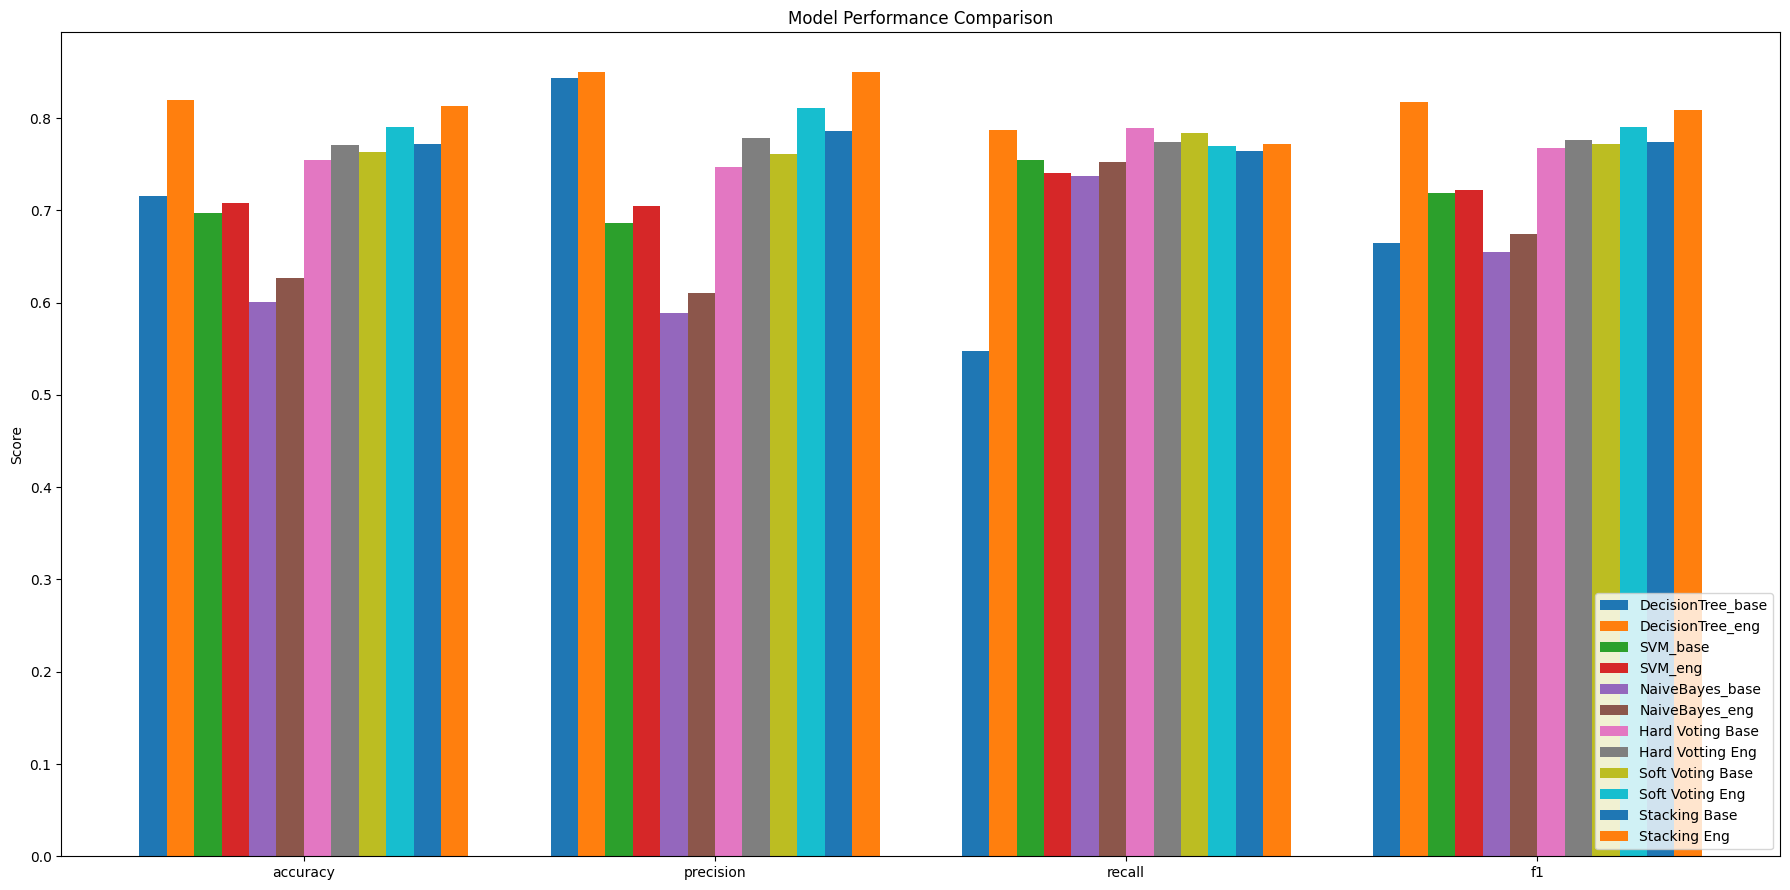

In [43]:
def plot_model_comparison(results_dict, metrics=['accuracy', 'precision', 'recall', 'f1']):
    """
    Creates a bar graph comparing model performance across different metrics.

    Args:
        results_dict (dict): A dictionary where keys are model names
                             and values are dictionaries containing metrics.
                             Example:
                             {'Model1': {'accuracy': 0.8, 'precision': 0.7, ...},
                              'Model2': {'accuracy': 0.9, 'precision': 0.8, ...}}
        metrics (list): A list of metrics to include in the comparison.
    """

    model_names = list(results_dict.keys())
    num_models = len(model_names)
    num_metrics = len(metrics)

    # Create arrays for plotting
    metric_values = np.zeros((num_models, num_metrics))
    for i, model_name in enumerate(model_names):
        for j, metric in enumerate(metrics):
            metric_values[i, j] = results_dict[model_name]['test_metrics'][metric] # Using test_metrics here

    # Set up the plot
    fig, ax = plt.subplots(figsize=(18, 9))
    bar_width = 0.8 / num_models  # Adjust bar width based on number of models
    x_pos = np.arange(num_metrics)

    # Create bars for each model
    for i, model_name in enumerate(model_names):
        ax.bar(x_pos + i * bar_width, metric_values[i, :], bar_width, label=model_name)

    # Customize the plot
    ax.set_xticks(x_pos + bar_width * (num_models -1)/ 2)
    ax.set_xticklabels(metrics)
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# Example Usage (assuming you have results stored in variables like results_hard, results_stacking, etc.)
all_results = {
    "DecisionTree_base" : models_results['DecisionTree_base'],
    "DecisionTree_eng": models_results['DecisionTree_eng'],
    "SVM_base": models_results['SVM_base'],
    "SVM_eng": models_results['SVM_eng'],
    "NaiveBayes_base": models_results['NaiveBayes_base'],
    "NaiveBayes_eng": models_results['NaiveBayes_eng'],
    "Hard Voting Base": results_hard,
    "Hard Votting Eng": results_hard_eng,
    "Soft Voting Base": results,
    "Soft Voting Eng": results_eng,
    "Stacking Base": results_stacking,
    "Stacking Eng": results_stacking_eng,
}

plot_model_comparison(all_results)